In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os



Using TensorFlow backend.
C:\Users\ningesh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ningesh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ningesh\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ningesh\App

In [2]:
data = pd.read_csv('uci-news-aggregator.csv', usecols=['TITLE', 'CATEGORY'])

In [3]:
#I do aspire here to have balanced classes
num_of_categories = 45000
shuffled = data.reindex(np.random.permutation(data.index))
e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories]
concated = pd.concat([e,b,t,m], ignore_index=True)
#Shuffle the dataset
concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

In [4]:
#One-hot encode the lab
concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3
print(concated['LABEL'][:10])
labels = to_categorical(concated['LABEL'], num_classes=4)
print(labels[:10])
if 'CATEGORY' in concated.keys():
    concated.drop(['CATEGORY'], axis=1)

101282    2
103490    2
173223    3
145819    3
125989    2
59244     1
4929      0
118109    2
14235     0
79199     1
Name: LABEL, dtype: int64
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [5]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(concated['TITLE'].values)
sequences = tokenizer.texts_to_sequences(concated['TITLE'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X = pad_sequences(sequences, maxlen=max_len)

Found 51879 unique tokens.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

In [7]:
epochs = 10
emb_dim = 128
batch_size = 256
labels[:2]

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [8]:
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))

model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=7, min_delta=0.0001)])

((135000, 130), (135000, 4), (45000, 130), (45000, 4))
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 130, 128)          1024000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 130, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 1,073,668
Trainable params: 1,073,668
Non-trainable params: 0
_________________________________________________________________
None

Train on 108000 samples, validate on 27000 samples
Epoch 1/10
108000/108000 [==============================] - 145s 1ms/step - loss: 0.8834 - acc: 0.6412 - val_loss: 0.3431 - val_ac

In [9]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

45000/45000 [==============================] - 33s 728us/step
Test set
  Loss: 0.235
  Accuracy: 0.919


In [13]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import numpy as np
predictions1=model.predict(X_test)
predictions=np.argmax(predictions, axis=1)
y_test1=np.argmax(y_test, axis=1)
print(y_test1)
print('------')
print(predictions)


[0 0 1 ... 2 3 0]
------
[0 0 2 ... 2 3 0]


In [14]:
print("Accuracy score: ", accuracy_score(y_test1, predictions))
print("Recall score: ", recall_score(y_test1, predictions, average = 'weighted'))
print("Precision score: ", precision_score(y_test1, predictions, average = 'weighted'))
print("F1 score: ", f1_score(y_test1, predictions, average = 'weighted'))

Accuracy score:  0.9192888888888889
Recall score:  0.9192888888888889
Precision score:  0.9193517583195842
F1 score:  0.9193001691188087


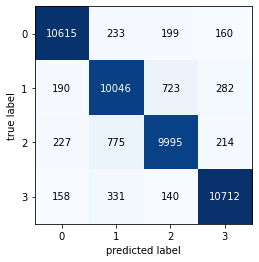

In [16]:
# Example of a confusion matrix in Python
from sklearn.metrics import confusion_matrix

#listofclasses


expected =y_test1.tolist()
predicted =predictions.tolist() 
#print(expected)
#print(predicted)
results = confusion_matrix(expected, predicted)
#print(results)
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

binary1 = np.array(results)

fig, ax = plot_confusion_matrix(conf_mat=binary1)
plt.show()